# WeatherPy
----

### Analysis
* As expected, the weather becomes significantly warmer as one approaches the equator (0 Deg. Latitude). More interestingly, however, is the fact that the southern hemisphere tends to be warmer this time of year than the northern hemisphere. This may be due to the tilt of the earth.
* There is no strong relationship between latitude and cloudiness. However, it is interesting to see that a strong band of cities sits at 0, 80, and 100% cloudiness.
* There is no strong relationship between latitude and wind speed. However, in northern hemispheres there is a flurry of cities with over 20 mph of wind.

---

#### Note
* Instructions have been included for each segment. You do not have to follow them exactly, but they are included to help you think through the steps.

In [25]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
import urllib
import openweathermapy as owm
from time import sleep
import seaborn as sbn
from scipy import stats
# Import API key
from api_keys import api_key
import warnings
warnings.filterwarnings('ignore')
# Incorporated citipy to determine city based on latitude and longitude
from citipy import citipy

# Output File (CSV)
output_data_file = "output_data/cities.csv"

# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)

## Generate Cities List

In [179]:
# Create a function to make a list of random coordinates and pick the nearest city
cities = []
def city_list():
    # List for holding lat_lngs and cities
    lat_lngs = []
    # Create a set of random lat and lng combinations
    lats = np.random.uniform(low=-90.000, high=90.000, size=1500)
    lngs = np.random.uniform(low=-180.000, high=180.000, size=1500)

    lat_lngs = zip(lats, lngs)
    # Identify nearest city for each lat, lng combination
    for lat_lng in lat_lngs:
        city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name

        # If the city is unique, then add it to a our cities list
        if city not in cities:
            cities.append(city)
    return cities
    city_sets(cities)

# city_list() <---Comment this out until you want to run it

# Print the city count to confirm sufficient count
len(cities)

0

## Break up the cities list into sets for API calls

In [63]:
# Commenting this out so we do not re-run and overwrite the data

# Create a function to break up the list of cities into sets

def city_sets(cities):
    arr = np.arange(0, len(cities), round(len(cities)/12))
    arr= np.append(arr,len(cities))
    sets = []
    for i in range(len(arr)-1):
        sets.append([arr[i], arr[i+1]])

    return sets


### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it\'s being processed (with the city number and city name).


In [192]:
# Create a function to do the API calls
##Create a list to store the responses
logfile = 'logfile.txt'

def owm_api(cities, sets, log, output):

    weather_data = []
    # Create a settings object with the API key and preferred units
    settings = {"units": "metric", "appid": api_key}

    # Create a list of parameters to keep
    summary = ["name","main.humidity", "main.temp_min","main.temp_max","wind.speed","clouds.all" ,"dt","sys.country", "sys.sunrise","sys.sunset","coord.lat", "coord.lon"]

    # Work with the log file to record the API calls/errors

    with open(log, 'w') as log:  

        for n in range(0, len(sets)-1):
            # Generate a list of cities for each subset range
            sub_cities = cities[sets[n][0]:sets[n][1]]

            for city in sub_cities:
                status = (f"Getting data for set number {n}: {city}... ")
                log.write(status)
                print(status)
                #Perform the API call on OWM 
                try:
                    city_data = owm.get_current(city, **settings)
                    weather_data.append(city_data)

                    #Log the result
                    msg = 'Success!\n'
                    log.write(msg)
                    print(msg)
                except urllib.error.HTTPError:
                    msg = 'City not found\n'
                    log.write(msg)
                    print(msg)
            # Account is limted to 60 calls per minute. Pause between each set.        
            sleep(55)

    data = [response(*summary) for response in weather_data]
    weather_df(data, output)


### Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

In [193]:
# Create a function to generate a dataframe, then CSV copy of the dataframe

def weather_df(data, filename):
    column_names = ["City","Humidity", "Min Temp","Max Temp","Wind Speed","Cloudiness","Date","Country","Sunrise","Sunset","Lat","Lon"]
    weather_data = pd.DataFrame(data, columns=column_names)
    weather_data.set_index('City')
    weather_data.to_csv(filename, encoding='UTF-8', header=True)


In [115]:
# Need to find out how to get line breaks to work
def w_stats(col1, col2):
    slope, intercept, r_value, p_value, std_err = stats.linregress(col1, col2)
    s_stats = f'Slope: {slope}. Intercept: {intercept}. R: {r_value}. P: {p_value}. SE: {std_err}'
    return s_stats

In [238]:
#For offline analysis, go back to the original csv file
def weather_analysis(filename):

    weather_data = pd.read_csv(filename, encoding='UTF-8', index_col=0, parse_dates=True, infer_datetime_format=True)
    weather_data['Daytime'] = ''
    weather_data.set_index('City', drop=True)
    return weather_data

weather_data = weather_analysis('test.csv')

In [239]:
# I want to see if there is a difference between daytime and nighttime, so calculating if time of data retrieval 
# is between sunrise and sunset (day) or not (night)

for i in range(0,len(weather_data)):
    if (weather_data.iloc[i,6] - weather_data.iloc[i,8]) >= 0 and (weather_data.iloc[i,6] - weather_data.iloc[i,9]) < 0:
        weather_data.iloc[i,12] = 'Day'
    else:
        weather_data.iloc[i,12] = 'Night'


In [262]:
# Convert the Date (data retrieval) from Epoch to readable time
weather_data['Date(GMT)'] = pd.to_datetime(weather_data['Date'], unit='s').dt.strftime('%m-%d-%Y: %H:%M')
adate = weather_data['Date(GMT)'][0]

In [241]:
# For statistical analysis, we will consider absolute latitude
weather_data['Absolute Latitude'] = abs(weather_data['Lat'])

### Testing the distribution of the random cities by plotting latitude/longitude

* Is the distribution of cities roughly similar to the complete list of available cities in the OWM database?
- Plot out the latitude/longitude of the random sample using Citipy
- Plot out a random sample from the complete list of cities on OWM from their JSON file of cities
- Compare the slope and intercepts of each

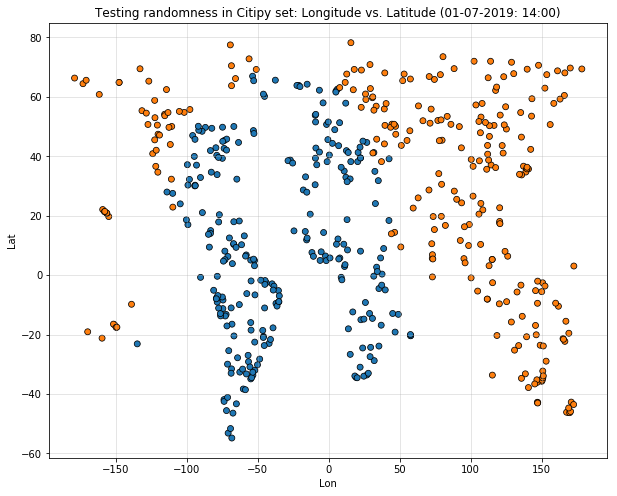

In [254]:
sbn.scatterplot(data=weather_data, x='Lon', y='Lat', hue='Daytime', legend=False, edgecolor='black')
fig = plt.gcf()
fig.set_size_inches(10, 8)
fig.ylimit=(-60,45)
fig.xlimit=(-65,85)
plt.grid(alpha=0.4)
plt.title(f"Testing randomness in Citipy set: Longitude vs. Latitude ({adate})")
plt.savefig('Citipy randomness test')

### Latitude vs. Temperature Plot
- Temperature has an inverse relationship to the absolute value of the latitude
- This demonstrates that temperatures do rise as you near the equator
- There is a different slope to the relationship for temperatures measured during the day and night
- P-values are significant in all three measures - combined, daytime and nighttime

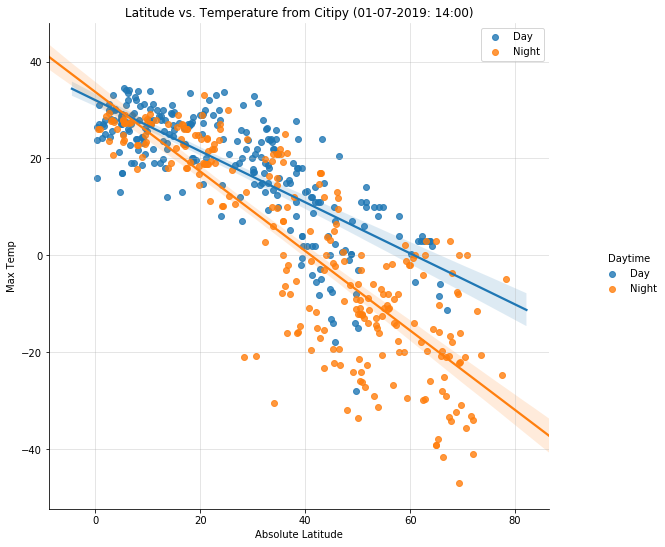

In [256]:
sbn.lmplot(data=weather_data, x='Absolute Latitude', y='Max Temp', hue='Daytime', legend=True)
fig = plt.gcf()
fig.set_size_inches(10, 8)
fig.ylimit=(-60,45)
fig.xlimit=(-65,85)
plt.grid(alpha=0.4)
plt.title(f"Latitude vs. Temperature from Citipy ({adate})")
plt.legend(loc='best')
plt.savefig('Citipy_temp_lat.png')


In [257]:
# get coeffs of linear fit for the full dataset
w_stats(weather_data['Absolute Latitude'], weather_data['Max Temp'])

'Slope: -0.7611675639161194. Intercept: 34.79229133463255. R: -0.8257587729521499. P: 1.999914912238503e-131. SE: 0.022799355135761066'

In [258]:
# get coeffs of linear fit for cities that were in nighttime when data was collected
night_df = weather_data.loc[weather_data.Daytime=='Night',:]
w_stats(night_df['Absolute Latitude'], night_df['Max Temp'])

'Slope: -0.8212563491060049. Intercept: 33.73394444644981. R: -0.8375107844554487. P: 2.0765630001537552e-69. SE: 0.03342327403461501'

In [259]:
# get coeffs of linear fit for cities that were in daytime when data was collected
day_df = weather_data.loc[weather_data.Daytime=='Day',:]
w_stats(day_df['Absolute Latitude'], day_df['Max Temp'])

'Slope: -0.5275382145582684. Intercept: 32.04071006739009. R: -0.7696209757336896. P: 8.973754451904773e-53. SE: 0.027090584274665392'

### Latitude vs. Humidity Plot
- The dataset had one outlier where humidity was greater than 100 percent, so that was removed
- The relationship between humidity and latitude was not significant for the whole dataset.
- However, there was a significant increase in humidity in cities nearer to the equator at night (P=1.95e-08).
- That increase was not reflected in subsequent runs and could have been the result of a specific weather pattern.
- There was no significant difference in humidity in cities based on latitude during the day .

In [260]:
#Removing one outlier that had a humidity of 300%
weather_data_f = weather_data[np.abs(weather_data.Humidity-weather_data.Humidity.mean()) <= (3*weather_data.Humidity.std())]


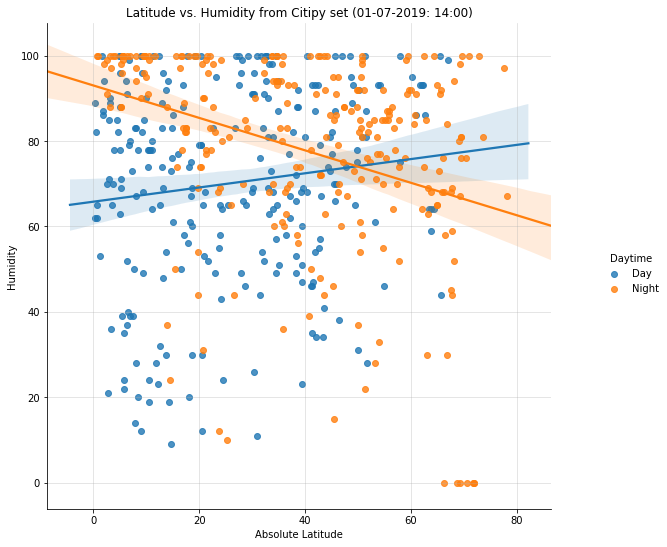

In [264]:
sbn.lmplot(data=weather_data_f, x='Absolute Latitude', y='Humidity', hue='Daytime', legend=True)
fig = plt.gcf()
fig.set_size_inches(10, 8)
plt.grid(alpha=0.4)
plt.title(f"Latitude vs. Humidity from Citipy set ({adate})")
# plt.legend(loc='best')
plt.savefig('Citipy_humid_lat.png')

In [265]:
# get coeffs of linear fit for the full dataset
w_stats(weather_data['Absolute Latitude'], weather_data['Humidity'])

'Slope: -0.10004164340597801. Intercept: 77.71071353037559. R: -0.0801388953370622. P: 0.06732279373929621. SE: 0.054567835113346896'

In [266]:
# get coeffs of linear fit for cities in nighttime
w_stats(night_df['Absolute Latitude'], night_df['Humidity'])

'Slope: -0.3798539354878763. Intercept: 92.99002826378405. R: -0.3401641078214731. P: 1.9507027755354177e-08. SE: 0.06550260021472432'

In [267]:
# get coeffs of linear fit for cities in daytime
w_stats(day_df['Absolute Latitude'], day_df['Humidity'])

'Slope: 0.10728229742124394. Intercept: 68.18971974538427. R: 0.06959300930737315. P: 0.26075980733662824. SE: 0.0951892610513219'

#### Cloudiness Plot
- We could find no apparent relationship between cloudiness and latitude or longitude in the dataset in other plots.
- This plot shows the clusters of cloudy regions based on latitude and longitude.
- At the time of data collection, it was cloudy in portions of Canada, South America, Northern Europe
- At the time of data collection it was largely clear across the equator.

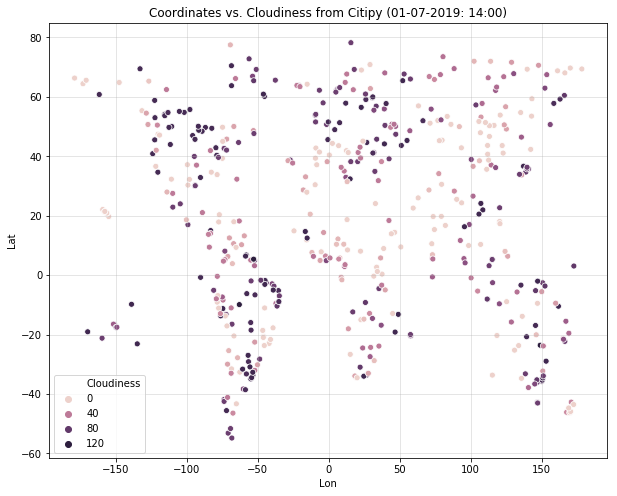

In [270]:
sbn.scatterplot(data=weather_data, x='Lon', y='Lat', hue='Cloudiness')
fig = plt.gcf()
fig.set_size_inches(10, 8)
fig.ylimit=(-60,45)
fig.xlimit=(-65,85)

plt.grid(alpha=0.4)
plt.title(f"Coordinates vs. Cloudiness from Citipy ({adate})")
# plt.legend(loc='best')
plt.savefig('Citipy_cloud_coord.png')

#### Latitude vs. Wind Speed Plot
- There was no direct relationship between latitude or longitude and wind
- There was a cluster of windiness in Northern Europe and South America.


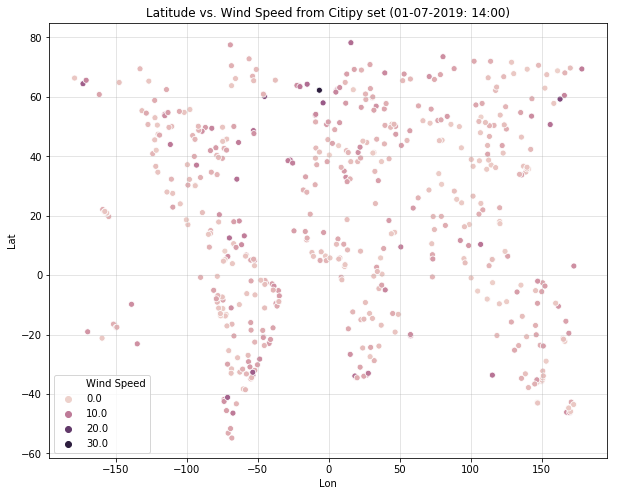

In [271]:
sbn.scatterplot(data=weather_data, x='Lon', y='Lat', hue='Wind Speed', legend='brief')
fig = plt.gcf()
fig.set_size_inches(10, 8)
fig.ylimit=(-60,45)
fig.xlimit=(-65,85)
plt.grid(alpha=0.4)
plt.title(f"Latitude vs. Wind Speed from Citipy set ({adate})")
# plt.legend(loc='best')
plt.savefig('Citipy_wind_coord.png')

### Checking distribution of coordinates in OpenWeatherMapy's JSON city list

In [174]:
# Getting the data from OWM (downloaded from their site locally) city list and putting it in a dataframe

##-----Put the complete city list into a dataframe
response = 'city.list.json'
owm_city_df = pd.read_json(response, convert_dates=True, encoding='UTF-8')

## Taking a random sample of a similar size to the first using Pandas sample, 
## then saving out to a CSV for further analysis
##----Breaking up coordinates into separate columns then stitch back into dataframe

data = owm_city_df['coord'].to_dict()
lat = []
lon = []
df = pd.DataFrame()
df['OWMLat'] = ''
df['OWMLon'] = ''
#Probably can just use a numpy random range for this...
for i in data:
    lat.append(data[i]['lat'])
    lon.append(data[i]['lon'])

owm_city_df['OWMLat'] = lat
owm_city_df['OWMLon'] = lon
owm_city_df.head()

,coord,country,id,name,OWMLat,OWMLon
0,"{'lon': 34.283333, 'lat': 44.549999}",UA,707860,Hurzuf,44.549999,34.283333
1,"{'lon': 37.666668, 'lat': 55.683334}",RU,519188,Novinki,55.683334,37.666668
2,"{'lon': 84.633331, 'lat': 28}",NP,1283378,Gorkhā,28.000000,84.633331
3,"{'lon': 76, 'lat': 29}",IN,1270260,State of Haryāna,29.000000,76.000000
4,"{'lon': 33.900002, 'lat': 44.599998}",UA,708546,Holubynka,44.599998,33.900002


In [176]:
dfs = owm_city_df.sample(frac=0.003, replace=True)

dfs.to_csv('owm_cities_sample.csv', encoding='utf-8', index=False, header=True)

In [177]:
owm_sample = pd.read_csv('owm_cities_sample.csv', encoding='utf-8')
owm_sample.head()

,coord,country,id,name,OWMLat,OWMLon
0,"{'lon': -9.10639, 'lat': 52.671669}",IE,2963385,Killadysert,52.671669,-9.106390
1,"{'lon': 117.116669, 'lat': 33.166672}",CN,1816945,Baoji,33.166672,117.116669
2,"{'lon': 37.859444, 'lat': 55.27861}",RU,817687,Yarlykovo,55.278610,37.859444
3,"{'lon': 3.87787, 'lat': 45.031551}",FR,2970826,Vals-pres-le-Puy,45.031551,3.877870
4,"{'lon': 12.16488, 'lat': 47.267639}",AT,7872252,Wald im Pinzgau,47.267639,12.164880


## Random latitude/longitude-Citipy sample vs. OWM city sample
* Initially, I doubted the randomness of the citipy approach, so I obtained the JSON list of all cities in OWM\'s database. 
* From the scatterplot below, it is apparent that OWM\'s database is heavily skewed toward Europe, likely due to density.
* This would likely skew the data for temperature, but we tried anyhow.

In [194]:

# cities = owm_sample['name'].tolist()
# sets = city_sets(cities)

# owm_api(cities, sets, 'owm_log.txt', 'owm_data.csv')

Getting data for set number 0: Killadysert... 
Success!

Getting data for set number 0: Baoji... 
Success!

Getting data for set number 0: Yarlykovo... 
Success!

Getting data for set number 0: Vals-pres-le-Puy... 
Success!

Getting data for set number 0: Wald im Pinzgau... 
Success!

Getting data for set number 0: Guagua... 
Success!

Getting data for set number 0: Willanzheim... 
Success!

Getting data for set number 0: Loíza Municipio... 
Success!

Getting data for set number 0: Unanu Municipality... 
Success!

Getting data for set number 0: Negenborn... 
Success!

Getting data for set number 0: Buadiposo-Buntong... 
Success!

Getting data for set number 0: Cangas... 
Success!

Getting data for set number 0: Penamacor... 
Success!

Getting data for set number 0: Casalbordino... 
Success!

Getting data for set number 0: Tlapa de Comonfort... 
Success!

Getting data for set number 0: Arrondissement de Vienne... 
Success!

Getting data for set number 0: Ochamchire... 
Success!

Getting

Success!

Getting data for set number 2: Sivaki... 
Success!

Getting data for set number 2: Hohen-Sülzen... 
Success!

Getting data for set number 2: Saint-Ouen-en-Belin... 
Success!

Getting data for set number 2: Venustiano Carranza... 
Success!

Getting data for set number 2: Rietdorf... 
Success!

Getting data for set number 2: Zwingen... 
Success!

Getting data for set number 2: Kemmern... 
Success!

Getting data for set number 2: Longuesaigne... 
Success!

Getting data for set number 2: Banaba... 
Success!

Getting data for set number 2: Liberty... 
Success!

Getting data for set number 2: Liceia... 
Success!

Getting data for set number 2: Hongjiang... 
Success!

Getting data for set number 3: Appomattox... 
Success!

Getting data for set number 3: Tỉnh Vĩnh Phúc... 
Success!

Getting data for set number 3: Litzelsdorf... 
Success!

Getting data for set number 3: Salvador Alvarado... 
City not found

Getting data for set number 3: Ruber... 
Success!

Getting data for set number

Success!

Getting data for set number 5: Moana... 
Success!

Getting data for set number 5: Fantanele... 
Success!

Getting data for set number 5: Bammental... 
Success!

Getting data for set number 5: Altenriet... 
Success!

Getting data for set number 5: Straßlach-Dingharting... 
City not found

Getting data for set number 5: Vale da Pinta... 
Success!

Getting data for set number 5: Edderton... 
Success!

Getting data for set number 5: Valmacca... 
Success!

Getting data for set number 5: Hualingang... 
Success!

Getting data for set number 5: Cayenne... 
Success!

Getting data for set number 5: Bellosguardo... 
Success!

Getting data for set number 5: Zonguldak... 
Success!

Getting data for set number 5: Fontioso... 
Success!

Getting data for set number 5: Osh... 
Success!

Getting data for set number 5: Reading... 
Success!

Getting data for set number 5: Ponce Inlet... 
Success!

Getting data for set number 5: Rianxo... 
Success!

Getting data for set number 5: Cherven... 
Succ

Success!

Getting data for set number 8: Padasono... 
Success!

Getting data for set number 8: Vernon River... 
Success!

Getting data for set number 8: Riggs Creek... 
Success!

Getting data for set number 8: Kirtland... 
Success!

Getting data for set number 8: Carbajal de la Legua... 
Success!

Getting data for set number 8: Hojo... 
Success!

Getting data for set number 8: Platanal... 
Success!

Getting data for set number 8: Sydney... 
Success!

Getting data for set number 8: Otoka... 
Success!

Getting data for set number 8: La Torre de Esteban Hambran... 
Success!

Getting data for set number 8: Jiajuedibu... 
Success!

Getting data for set number 8: Hueypoxtla... 
Success!

Getting data for set number 8: Muravlenko... 
Success!

Getting data for set number 8: Departamento de San Cosme... 
Success!

Getting data for set number 8: Lenzen... 
Success!

Getting data for set number 8: Coihueco... 
Success!

Getting data for set number 8: Puentes de Garcia Rodriguez... 
Success!

Get

Success!

Getting data for set number 11: Shani... 
Success!

Getting data for set number 11: Koyasu... 
Success!

Getting data for set number 11: Wentworthville... 
Success!

Getting data for set number 11: West Summit... 
Success!

Getting data for set number 11: Meudt... 
Success!

Getting data for set number 11: Antigua... 
Success!

Getting data for set number 11: Carbury... 
Success!

Getting data for set number 11: Berryville... 
Success!

Getting data for set number 11: Carbonera... 
Success!

Getting data for set number 11: Beechmont... 
Success!

Getting data for set number 11: Waldzell... 
Success!

Getting data for set number 11: Weißenohe... 
Success!

Getting data for set number 11: Kolej... 
Success!

Getting data for set number 11: Villa Bisono... 
Success!

Getting data for set number 11: Farcasesti... 
Success!

Getting data for set number 11: Olofstroem... 
Success!

Getting data for set number 11: Arica... 
Success!

Getting data for set number 11: Bramstedtlund... 